In [83]:
import numpy as np
import scipy.ndimage as ndi
import skimage as sim
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from collections import deque
import itertools
import my_starconvex
import shapely
import random
import timeit

In [2]:
obr = imread("../Dane/rawimages/Neuroblastoma_7.tif")
obr = (obr - np.min(obr))/(np.max(obr)-np.min(obr))

obrScharr = sim.filters.scharr(obr)
obrScharr = (obrScharr - np.min(obrScharr))/(np.max(obrScharr)-np.min(obrScharr))

In [3]:
def czyszczenieIfConv(obr, treshold_low=0.1, treshold_high=0.4, target=0.0, maxNotInRange=0):
    obr = obr.copy()
    obr[0,:]=0
    obr[:,0]=0
    obr[:,-1]=0
    obr[-1,:]=0
    q = deque(wsp for wsp in itertools.product(range(1,obr.shape[0]-1), range(1,obr.shape[1]-1)))
    while q:
        wsp = q.popleft()
        if 0 in wsp or wsp[0]==obr.shape[0]-1 or wsp[1]==obr.shape[1]-1:
            continue
        if obr[wsp] == target:
            continue
        notInRange=0
        neigh = []
        for shift in itertools.product([-1,0,1],repeat=2):
            if shift==(0,0):
                continue
            nWsp = (wsp[0]+shift[0], wsp[1]+shift[1])
            neigh.append(nWsp)
            if obr[nWsp]<treshold_low or obr[wsp]>treshold_high:
                notInRange+=1
        if notInRange<=maxNotInRange:
            obr[wsp]=target
            q += neigh
    return obr

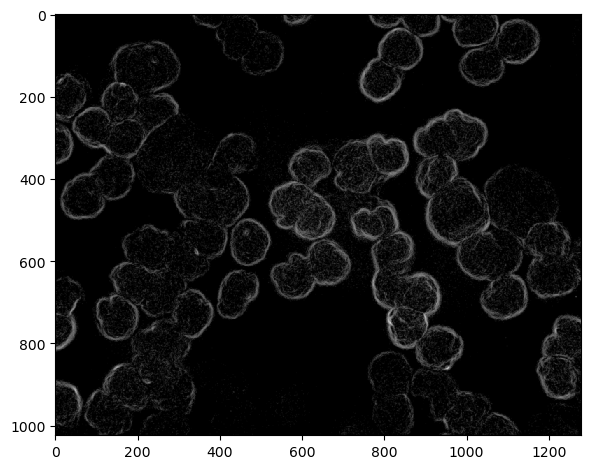

In [4]:
obrRemvBgNoise = czyszczenieIfConv(obrScharr, treshold_low=-1, treshold_high=0.2)
obrRemvBgNoise = sim.filters.gaussian(obrRemvBgNoise,1)
imshow(obrRemvBgNoise)

In [82]:
LIM=400
n_rays = 64
st_rays = np.pi*2 /n_rays
max_steps = 100

In [63]:
dst=my_starconvex.stardist(obrRemvBgNoise[:LIM,:LIM], n_rays, 0.005, 0.18,max_steps)

42.9 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

372 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [64]:
def printPointsOverImage(img, pointMask):
    vs=[]
    for x,y in itertools.product(range(img.shape[0]), range(img.shape[1])):
        if pointMask[x,y]:
            #print(x,y)
            vs.append((x,y))
    vs=np.array(vs)
    plt.scatter(vs[:,1], vs[:,0])
    imshow(img)

In [65]:
background_mask =np.logical_not(np.all(dst==2147483647,axis=(2,3)))

v_min=np.min(dst,2)
v_max=np.max(dst,2)

ration_mask = np.logical_and((v_min*1.5) > v_max, background_mask.reshape(*background_mask.shape,-1))
ration_mask = np.logical_and(ration_mask, dstS<1500)

for i in [35,40,45,50,60,75]:
    printPointsOverImage(obrRemvBgNoise, ration_mask[:,:,i])
    plt.show()

In [66]:
ret = my_starconvex.analyse_dst(dst, 3)

TUTAJ3


In [67]:
paths = ret[:,:,:,1:]
ret = ret[:,:,:,0]

In [68]:
ret.shape

(400, 400, 100)

In [69]:
retm = np.argmin(ret,2)

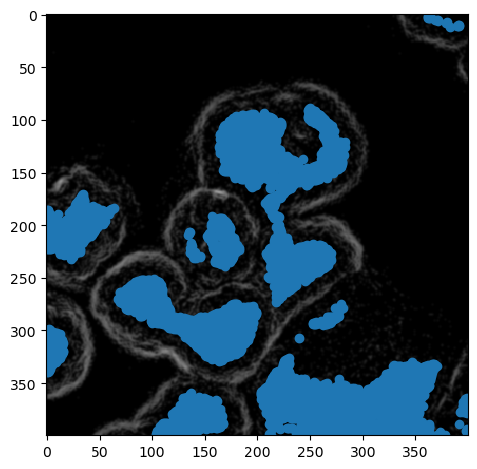

In [70]:
printPointsOverImage(obrRemvBgNoise[:LIM,:LIM], retm>20)

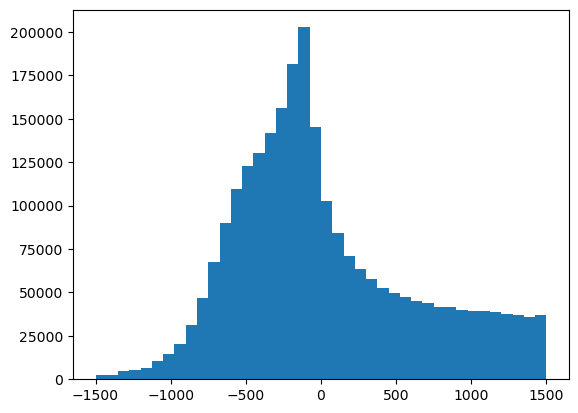

In [23]:
plt.hist(ret.reshape(-1),range=(-1500,1500), bins=40)
plt.show()

In [24]:
wagi = np.arange(100).reshape(1,1,-1)*(0)

In [25]:
retw=ret+wagi

In [26]:
retwm=np.argmin(retw,2)

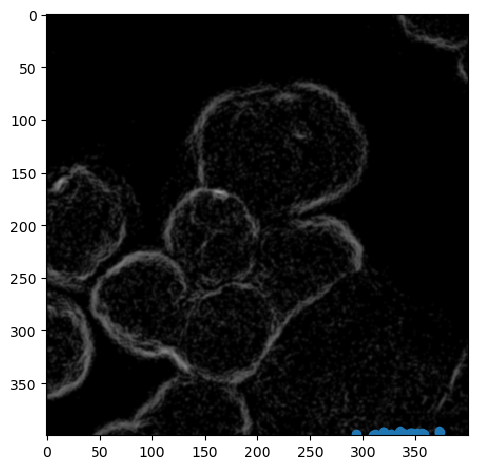

In [27]:
printPointsOverImage(obrRemvBgNoise[:LIM,:LIM], np.logical_and(background_mask, retwm>85))

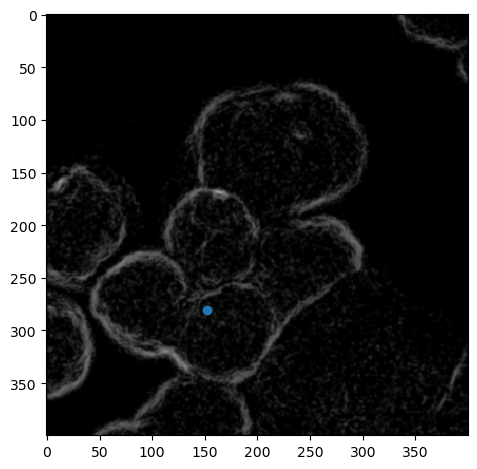

In [28]:
imshow(obrRemvBgNoise[:LIM,:LIM])
plt.scatter(152,281)

In [29]:
i=0
for p in paths[152,281]:
    print(p)
    i+=1
    if i==10:
        break

[ 0  2  4  6  8 10 12 14 16 18 18 17 16 14 12 12 14 14 16 18 20 22 24 26
 28 28 28 26 26 26 28 30 32 32 31 29 27 25 23 23 25 23 23 23 25 25 25 23
 22 22 22 22 22 22 20 18 16 14 12 10  8  6  4  2]
[ 1  2  4  6  8 10 12 14 16 18 18 17 16 14 12 12 14 14 16 18 20 22 24 26
 28 28 28 26 26 26 28 30 32 32 31 29 27 25 23 23 23 22 22 24 26 28 27 25
 23 23 23 23 23 23 21 19 17 15 13 11  9  7  5  3]
[ 2  4  6  8 10 12 14 16 18 18 18 17 16 14 12 12 14 14 16 18 20 22 24 26
 28 28 28 26 26 26 28 30 32 32 31 29 27 25 23 23 23 22 22 24 26 28 27 25
 23 23 23 23 23 23 22 20 18 16 14 12 10  8  6  4]
[ 3  4  6  8 10 12 14 16 18 18 18 17 16 14 12 12 14 14 16 18 20 22 24 26
 28 28 28 26 26 26 28 30 32 32 31 29 27 25 23 23 23 22 22 24 26 28 27 25
 23 23 23 23 23 23 23 21 19 17 15 13 11  9  7  5]
[ 4  6  8 10 12 14 16 18 18 18 18 17 16 14 12 12 14 14 16 18 20 22 24 26
 28 28 28 26 26 26 28 30 32 32 31 29 27 25 23 23 25 23 23 23 25 25 25 23
 22 22 22 22 22 24 24 22 20 18 16 14 12 10  8  6]
[ 5  6  8 10 12 14 1

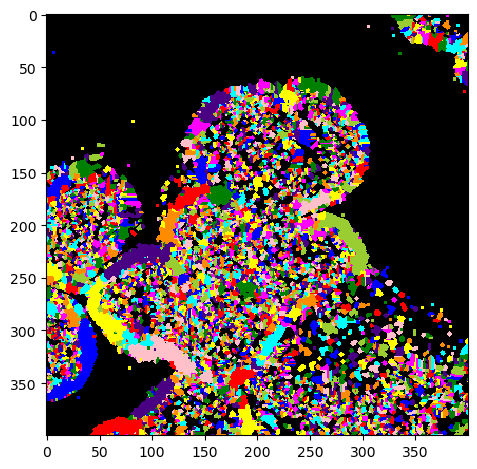

In [30]:
lab = sim.segmentation.watershed(sim.filters.gaussian(np.min(ret,2),0), mask=background_mask)
imshow(sim.color.label2rgb(lab))

In [31]:
def convertRayToPoint(st_rays, i, dl, x_mid, y_mid):
    phi = i*st_rays
    dy = np.cos(phi)
    dx = np.sin(phi)
    return (np.round(x_mid+dl*dx), np.round(y_mid+dl*dy))

In [32]:
def convertRaysToPoints(st_rays, n_rays, dl, x_mid, y_mid):
    return [convertRayToPoint(st_rays, k, dl, x_mid, y_mid) for k in range(n_rays)]

In [33]:
def convertPathToPoints(path, st_rays, x_mid, y_mid):
    return [convertRayToPoint(st_rays, i, dl, x_mid, y_mid) for i,dl in enumerate(path)]

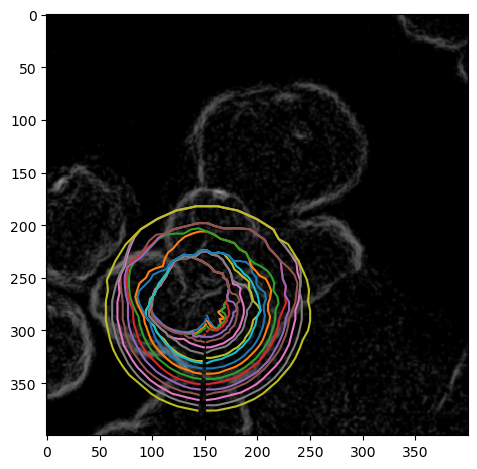

In [71]:
imshow(obrRemvBgNoise[:LIM,:LIM])
for dl in range(5, 99, 5):
    ppp=convertPathToPoints(paths[152,281,dl], st_rays, 152, 281)
    plt.plot(np.array(ppp)[:,0],np.array(ppp)[:,1])

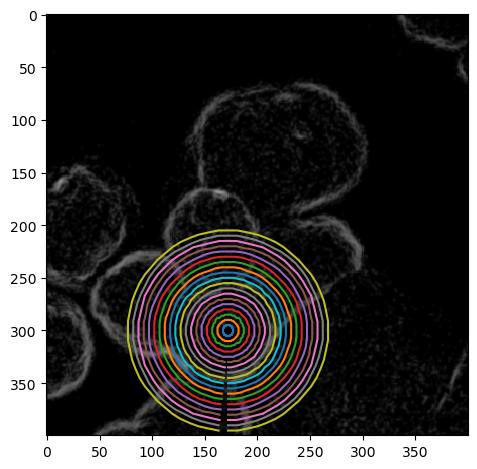

In [43]:
imshow(obrRemvBgNoise[:LIM,:LIM])
for dl in range(5, 99, 5):
    ppp=convertPathToPoints(paths[172,300,dl], st_rays, 172, 300)
    plt.plot(np.array(ppp)[:,0],np.array(ppp)[:,1])

In [96]:
P = shapely.Polygon(ppp)

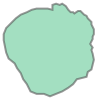

In [97]:
P

In [74]:
ret.shape

(400, 400, 100)

In [75]:
paths.shape

(400, 400, 100, 64)

In [ ]:
const_mutate_move = 3
const_mutate_size = 5
const_max_size = max_steps
const_st_rays = st_rays
const_cell_mutate_move_cum_prob = 0.7
const_cell_mutate_size_cum_prob = 1
const_indiv_mutate_cell_mut_cum_prob = 0.9
const_indiv_mutate_add_cum_prob = 0.95
const_indiv_mutate_remove_cum_prob = 1

class Cell():
    def __init__(self, x, y, size, max_x, max_y, paths, path_costs):
        self.x = x
        self.y = y
        self.size = size
        self.max_x=max_x
        self.max_y=max_y
        self.paths = paths
        self.path_costs = path_costs
        
    def mutate_move(self) -> None:
        dx, dy = np.random.randint(-const_mutate_move, const_mutate_move, size=2)
        self.x += dx
        self.y += dy
        if self.x<0:
            self.x=0
        if self.y<0:
            self.y=0
        if self.x>max_x:
            self.x=max_x
        if self.y>max_y:
            self.y=max_y
        
    def mutate_size(self) -> None:
        ds = np.random.randint(-const_mutate_size, const_mutate_size, size=1)
        self.size += ds
        if self.size<0:
            self.size=0
        if self.size >const_max_size:
            self.size = const_max_size
    
    def mutate(self):
        r = random.rand()
        if r < const_mutate_move_cum_prob:
            self.mutate_move()
        if r < const_mutate_size_cum_prob:
            self.mutate_size()
    
    def reduce_to_remove_conflict(self, other : Cell) -> bool:
        other_polygon = other.get_polygon()
        for s in range(self.size, -1, -1):
            self.size=s
            my_polygon = self.get_polygon()
            if not my_polygon.intersects(other_polygon):
                return True
        return False
        
    def get_polygon(self) -> shapely.Polygon:
        points = convertPathToPoints(self.paths[self.x, self.y, self.size], const_st_rays, self.x, self.y)
        return shapely.Polygon(points)
    
    def get_cost(self):
        return self.path_costs[self.x, self.y, self.size]

class Individual():
    def __init__(self, n_init_cells, max_x, max_y, paths, path_costs):
        self.n_init_cells = n_init_cells
        self.cells : list[Cell] = []
        self.max_x=max_x
        self.max_y=max_y
        self.paths = paths
        self.path_costs = path_costs
        
    def generate_cell(self) -> Cell:
        x = random.randrange(self.max_x)
        y = random.randrange(self.max_y)
        size = random.randrange(max_steps)
        c = Cell(x,y,size, self.max_x, self.max_y, self.paths, self.path_costs)
        return c
    
    def generate_initial(self):
        for i in range(self.n_init_cells):
            self.cells.append(self.generate_cell())
    
    def mutate_remove_cell(self):
        idx = random.randrange(len(self.cells))
        self.cells.pop(idx)
    
    def mutate_add_cell(self):
        c = generate_cell()
        self.fix_conflicts(c)
        cells.append(c)
    
    def mutate_cells(self):
        n = random.randrange(len(self.cells)//4, len(self.cells)//4*3)
        for _ in range(n):
            c = random.choice(self.cells)
            c.mutate()
            self.fix_conflicts(c)
    
    def mutate(self):
        r = random.rand()
        if r < const_indiv_mutate_cell_mut_cum_prob:
            self.mutate_cells()
        elif r < const_indiv_mutate_add_cum_prob:
            self.mutate_add_cell()
        elif r < const_indiv_mutate_remove_cum_prob:
            self.mutate_remove_cell()
        
    
    def crossover(self):
        raise NotImplementedError()
    
    def cost(self):
        return sum(c.get_cost for c in self.cells)
    
    def fix_conflicts(self, first_cell : Cell):
        q = deque(first_cell)
        while q:
            c_main = q.pop()
            c_main_poly = c_main.get_polygon()
            for c_snd in self.cells:
                if c_snd == c_main:
                    continue
                if c_main_poly.intersects(c_snd.get_polygon()):
                    ret = c_snd.reduce_to_remove_conflict()
                    if not ret:
                        self.cells.remove(c_snd)
                #q.append(c_snd)
    
    def assert_no_conflicts(self):
        for i in range(len(self.cells)):
            for j in range(i+1, len(self.cells)):
                c_1_poly = self.cells[i].get_polygon()
                c_2_poly = self.cells[j].get_polygon()
                assert not c_1_poly.intersects(c_2_poly)
    
class Genetic():
    def __init__(self, n_rays, paths, ret, n_individual):
        self.n_rays = n_rays
        self.ret = ret
        self.paths = paths
        self.n_individual = n_individual
        
        self.indiv = []
        
    def generate_individuals(self):
        TODO
        
    def fit(self):
        TODO